# Proyek Klasifikasi Gambar Kulit Wajah

---



## Menyiapkan Library

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import numpy as np
import matplotlib.pyplot as plt
import pathlib
import pandas as pd

## Preprocessing Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Path ke file dataset di Google Drive
file_path = '/content/drive/My Drive/CAPSTONE/dataset'

# Path ke direktori dataset
TRAINING_DIR = "/content/drive/My Drive/CAPSTONE/dataset/train"
VALIDATION_DIR = "/content/drive/My Drive/CAPSTONE/dataset/val"

train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.1
)

train_generator = train_datagen.flow_from_directory(TRAINING_DIR,
                                                    class_mode='categorical',
                                                    target_size=(150, 150)
                                                    )


Found 2756 images belonging to 3 classes.


In [ ]:
validation_datagen = ImageDataGenerator(
    rescale=1.0/255.
)
validation_generator = validation_datagen.flow_from_directory(VALIDATION_DIR,
                                                        class_mode='categorical',
                                                        target_size=(150, 150))


Found 321 images belonging to 3 classes.


## Membuat Model Klasifikasi Kelas

In [ ]:
# Load MobileNetV2 pre-trained model tanpa lapisan atas (include_top=False)
pre_trained_model = MobileNetV2(weights="imagenet", include_top=False,
                                input_shape=(150, 150, 3))
                                # input_tensor=Input(shape=(150, 150, 3))

9406464/9406464 [==============================] - 0s 0us/step


In [ ]:
# Mengunci semua layer di model pre-trained
# for layer in pre_trained_model.layers:
#     layer.trainable = False

pre_trained_model.trainable = False

In [ ]:
# # Mendapatkan output dari model pre-trained
# last_output = pre_trained_model.output

In [ ]:
# Menambahkan lapisan custom di atas model pre-trained
inputs = Input(shape=(150, 150, 3))
x = pre_trained_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)  # Dropout untuk mengurangi overfitting
outputs = Dense(3, activation='softmax')(x)  # Dua kelas: kering dan berminyak

In [ ]:
# Membuat model akhir
model = Model(inputs, outputs)

In [ ]:
# Kompilasi model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Melihat arsitektur model
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 mobilenetv2_1.00_224 (Func  (None, 5, 5, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 batch_normalization (Batch  (None, 1280)              5120      
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 512)               655872    
                                                             

## Melatih Model

In [ ]:
# Melatih model
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=200,
    verbose=1
)

Epoch 1/200
87/87 [==============================] - 480s 6s/step - loss: 1.5344 - accuracy: 0.4521 - val_loss: 1.2455 - val_accuracy: 0.4081
Epoch 2/200
87/87 [==============================] - 35s 404ms/step - loss: 1.2241 - accuracy: 0.5076 - val_loss: 1.4220 - val_accuracy: 0.3988
Epoch 3/200
87/87 [==============================] - 36s 411ms/step - loss: 1.1234 - accuracy: 0.5316 - val_loss: 1.1191 - val_accuracy: 0.5576
Epoch 4/200
87/87 [==============================] - 34s 386ms/step - loss: 1.0019 - accuracy: 0.5577 - val_loss: 1.3291 - val_accuracy: 0.3614
Epoch 5/200
87/87 [==============================] - 33s 377ms/step - loss: 0.9463 - accuracy: 0.5653 - val_loss: 1.2327 - val_accuracy: 0.4143
Epoch 6/200
87/87 [==============================] - 35s 398ms/step - loss: 0.9067 - accuracy: 0.5864 - val_loss: 1.2499 - val_accuracy: 0.3988
Epoch 7/200
87/87 [==============================] - 32s 371ms/step - loss: 0.8973 - accuracy: 0.5972 - val_loss: 1.4075 - val_accuracy: 0

In [ ]:
858/858 [==============================] - 13s 15ms/step - loss: 0.4434 - accuracy: 0.8506 - val_loss: 0.2081 - val_accuracy: 0.9225

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

# Membuat callback EarlyStopping
early_stopping = EarlyStopping(
    monitor='val_loss',  # Metrik yang dipantau
    patience=10,         # Jumlah epoch tanpa peningkatan setelah pelatihan dihentikan
    verbose=1,           # Menampilkan pesan saat pelatihan dihentikan
    restore_best_weights=True  # Mengembalikan bobot model ke yang terbaik
)

# Melatih model dengan Early Stopping
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=200,
    verbose=1,
    callbacks=[early_stopping]  # Menambahkan callback ke dalam pelatihan
)

Epoch 1/200
87/87 [==============================] - 562s 6s/step - loss: 1.6646 - accuracy: 0.4224 - val_loss: 1.4463 - val_accuracy: 0.4393
Epoch 2/200
87/87 [==============================] - 93s 1s/step - loss: 1.3287 - accuracy: 0.4877 - val_loss: 1.8143 - val_accuracy: 0.2368
Epoch 3/200
87/87 [==============================] - 93s 1s/step - loss: 1.1142 - accuracy: 0.5250 - val_loss: 1.7072 - val_accuracy: 0.2586
Epoch 4/200
87/87 [==============================] - 91s 1s/step - loss: 1.0453 - accuracy: 0.5356 - val_loss: 1.3632 - val_accuracy: 0.3364
Epoch 5/200
87/87 [==============================] - 94s 1s/step - loss: 0.9455 - accuracy: 0.5657 - val_loss: 1.4399 - val_accuracy: 0.2804
Epoch 6/200
87/87 [==============================] - 93s 1s/step - loss: 0.9186 - accuracy: 0.5867 - val_loss: 1.3848 - val_accuracy: 0.3645
Epoch 7/200
87/87 [==============================] - 94s 1s/step - loss: 0.8715 - accuracy: 0.6092 - val_loss: 1.2594 - val_accuracy: 0.4206
Epoch 8/200


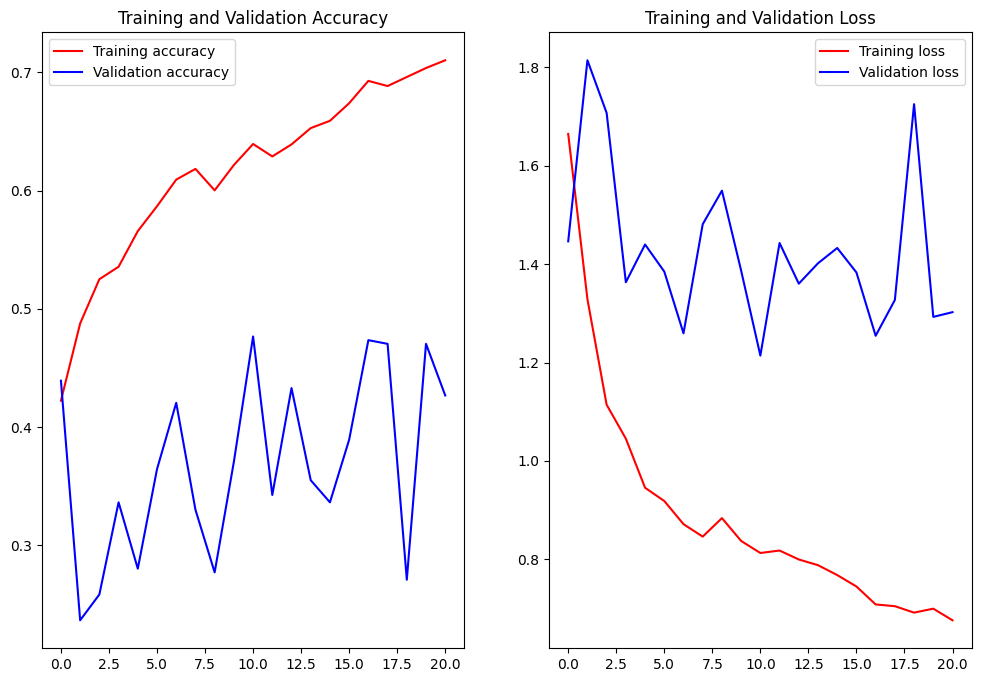

In [12]:
# Menampilkan akurasi dan loss dari pelatihan
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.figure(figsize=(12, 8))

plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.show()

In [13]:
model.save('skin_classifier_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [14]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model

# Load model yang telah dilatih
model_path = '/content/skin_classifier_model.h5'
model = load_model(model_path)

# Fungsi untuk memuat dan memproses gambar
def load_and_preprocess_image(img_path, target_size=(150, 150)):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0  # Normalisasi gambar
    return img_array

# Daftar path gambar untuk testing
test_image_paths = [
    '/content/drive/My Drive/CAPSTONE/dataset/zilong.jpg'
    # Tambahkan path gambar lainnya
]

# Daftar kelas
class_labels = ['normal', 'dry', 'oil']

# Loop melalui setiap gambar untuk melakukan prediksi
for img_path in test_image_paths:
    img_array = load_and_preprocess_image(img_path)
    predictions = model.predict(img_array)
    predicted_class = class_labels[np.argmax(predictions)]

    # Print hasil prediksi
    print(f"Gambar: {img_path} - Prediksi: {predicted_class}")

# # Fungsi untuk menguji satu gambar
# def test_single_image(model, img_path):
#     img_array = load_and_preprocess_image(img_path)
#     predictions = model.predict(img_array)
#     predicted_class = class_labels[np.argmax(predictions)]
#     confidence = np.max(predictions)

#     print(f"Prediksi untuk gambar {img_path}:")
#     print(f"Kelas: {predicted_class}, Kepercayaan: {confidence:.2f}")

# # # Test gambar tunggal
# # single_test_image_path = '/content/drive/My Drive/CAPSTONE/dataset/dry1.jpg'
# # test_single_image(model, single_test_image_path)


1/1 [==============================] - 1s 1s/step
Gambar: /content/drive/My Drive/CAPSTONE/dataset/zilong.jpg - Prediksi: normal


## Rekomendasi Skincare berdasarkan Klasifikasi Kelas

In [ ]:
# Fungsi untuk menampilkan rekomendasi skincare
def show_skincare_recommendation(pred_class):
    if pred_class == 0:  # Kering
        img_path = "/content/drive/My Drive/skincare_A.jpg"
        img = mpimg.imread(img_path)
        plt.imshow(img)
        plt.axis('off')
        plt.title("Rekomendasi Skincare: Produk A")
        plt.show()

        print("Nama Produk: Produk A")
        print("Ingredients: .................")
        print("Khasiat: .....................")
        print("Cara Pemakaian: ...............")
    elif pred_class == 1:  # Berminyak
        img_path = "/content/drive/My Drive/skincare_B.jpg"
        img = mpimg.imread(img_path)
        plt.imshow(img)
        plt.axis('off')
        plt.title("Rekomendasi Skincare: Produk B")
        plt.show()

        print("Nama Produk: Produk B")
        print("Ingredients: ,.............")
        print("Khasiat: .....................")
        print("Cara Pemakaian: ..................")

In [ ]:
# Import necessary libraries
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
import numpy as np
from PIL import Image

# Load the trained model
model = load_model('skin_classifier_model.h5')

# Define the skincare recommendations
recommendations = {
    'oil': {
        'name': 'Neutrogena Oil-Free Acne Wash',
        'image': 'https://images.neutrogena.com/is/image/Neutrogena/oil-free-acne-wash-main?qlt=85,0&resMode=sharp2&op_usm=1.1,0.4,1,0&hei=408&wid=408',
        'ingredients': ['Salicylic Acid (2%)', 'Water', 'Cocamidopropyl Betaine', 'Sodium C14-16 Olefin Sulfonate'],
        'benefits': ['Menghilangkan minyak berlebih di kulit', 'Membantu mencegah jerawat', 'Membersihkan pori-pori secara mendalam'],
        'usage': 'Basahi wajah dan oleskan produk ke tangan. Pijat lembut ke seluruh wajah, hindari area mata. Bilas hingga bersih dan keringkan.'
    },
    'dry': {
        'name': 'Cetaphil Moisturizing Cream',
        'image': 'https://www.cetaphil.com/dw/image/v2/BCCH_PRD/on/demandware.static/-/Sites-cetaphil-master-catalog/default/dw00c847d1/images/products/CET0060_1018.png',
        'ingredients': ['Water', 'Glycerin', 'Petrolatum', 'Dimethicone'],
        'benefits': ['Melembapkan kulit kering secara intensif', 'Membantu memperbaiki penghalang kelembapan alami kulit', 'Menenangkan kulit yang iritasi dan pecah-pecah'],
        'usage': 'Oleskan krim pada kulit yang bersih. Pijat lembut hingga meresap sempurna. Gunakan dua kali sehari, pagi dan malam, atau sesuai kebutuhan.'
    }
}

# Function to predict skin type
def predict_skin_type(image_path):
    img = Image.open(image_path).resize((150, 150))
    img_array = np.array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    prediction = model.predict(img_array)
    class_idx = np.argmax(prediction, axis=1)[0]
    return 'oil' if class_idx == 0 else 'dry'

# Function to get skincare recommendation
def get_recommendation(skin_type):
    return recommendations[skin_type]

# Example usage
image_path = 'path_to_test_image.jpg'
skin_type = predict_skin_type(image_path)
recommendation = get_recommendation(skin_type)

print(f"Recommended skincare for {skin_type} skin:")
print(f"Name: {recommendation['name']}")
print


## Mengubah Model

In [ ]:
# Konversi model Keras ke TFLite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

In [ ]:
# Menyimpan model TFLite
tflite_model_path = "/content/drive/My Drive/CAPSTONE/skinenthusiastmodel.tflite"
with open(tflite_model_path, 'wb') as f:
    f.write(tflite_model)

In [ ]:
#################